# Data generation

This module (meant for curve learner) defines classes for generating 1D curves of certain functional form with added noise. It also defines functionality for interpolating (downsampling) the curves using a set of available algorithms

In [1]:
# import all the neccessary modules
import numpy as np
import pandas as pd
import json
from scipy.signal import savgol_filter
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

## Curve Generator

This class creates melting curves with added noise. It is used for generating a benchmarking dataset for the **CurveLearner** 

In [2]:
class CurveGen(object):
    """class for generating thermal unfolding curves (1D)"""
    def __init__(self, seed=0, start=0, end=100, size=100, mid=50, width=0.5, 
                 noise=0.0, prob_missing=0, missing_size=(1,10), folded_base=[0.0], unfolded_base=[1.0]):
        self.seed = seed
        self.start = start
        self.end = end
        self.size = size
        self.params = {"mid":mid,
                       "width":width,
                       "folded": folded_base,
                       "unfolded": unfolded_base}
        self.noise_level = noise
        self.prob_missing = prob_missing
        # missing patch size cannot be larger than the total signal size
        if missing_size[1] < size:
            self.missing_size = missing_size
        else:
            self.missing_size = (missing_size[0], size - 1)
    
    def set_params(self, mid=None, width=None, folded=None, unfolded=None):
        """sets the function params
        folded - a list: polynomial coeff of the baseline signal for the folded state
        as a func. of temp. Example: [a0, a1, ...] where a0 is the lowest order coeff
        unfolded - a list: same as folded but for the unfolded state"""
        if mid:
            self.params["mid"] = mid
        if width:
            self.params["width"] = width
        if folded:
            self.params["folded"] = folded
        if unfolded:
            self.params["unfolded"] = unfolded
            
    def set_size(self, start=None, end=None, size=None):
        """sets the curve size and bounds"""
        if start:
            self.start = start
        if end:
            assert end > self.start, "curve endpoint must be larger than its start"
            self.end = end
        if size:
            self.size = size
    
    def set_noise(self, level):
        """sets the noise level in the data"""
        assert level >= 0, "noise must be positive"
        self.noise_level = level
        
    def set_missing(self, prob_missing, missing_size):
        """sets the missing data parameters"""
        assert prob_missing < 1 and prob_missing >= 0, "prob_missing must be in the range [0, 1)"
        self.prob_missing = prob_missing
        assert missing_size[1] < self.size, "missing_size must be smaller than the total signal size"
        self.missing_size = missing_size
        
    
    def randomize_params(self, start=None, end=None, size=None, mid=None, 
                         width=None, folded=None, unfolded=None, noise=None,
                         prob_missing=None, missing_size=None):
        """randomly sets the specified params within the given range
        start, end, size - tuples of integers [min, max)
        mid, width, noise, missing_size - tuples of floats [min, max)
        folded, unfolded - lists of tuples [(min1, max1)[,(min2, max2),...]
        prob_missing - tuple of floats (0 - 1)"""
        if start:
            self.start = np.random.randint(start[0], start[1])
        if end:
            self.end = np.random.randint(end[0], end[1])
        if size:
            self.size = np.random.randint(size[0], size[1])
        if mid:
            self.params["mid"] = np.random.uniform(mid[0], mid[1])
        if width:
            self.params["width"] = np.random.uniform(width[0], width[1])
        if folded:
            self.params["folded"] = [np.random.uniform(limits[0], limits[1]) 
                                     for limits in folded]
        if unfolded:
            self.params["unfolded"] = [np.random.uniform(limits[0], limits[1]) 
                                     for limits in unfolded]
        if noise:
            self.noise_level = np.random.uniform(noise[0], noise[1])
        if prob_missing:
            assert prob_missing[0] >= 0, "min prob_missing must be >= 0"
            assert prob_missing[1] < 1, "max prob_missing must be < 1"
            self.prob_missing = np.random.uniform(prob_missing[0], prob_missing[1])
        if missing_size:
            assert missing_size[1] < self.size, "missing_size must be smaller than the total signal size"
            self.missing_size = tuple(sorted(np.random.randint(missing_size[0],
                                                               missing_size[1], 2)))
        
    def make_baselines(self):
        """makes the x-values and the baselines of the two states"""
        x = np.linspace(self.start, self.end, num=self.size)
        base_f = np.polyval(self.params["folded"][::-1], x)
        base_u = np.polyval(self.params["unfolded"][::-1], x)
        return (x, base_f, base_u)
        
    def generate_curve(self):
        """generates a 2D array of size 'size' using
        the set params"""
        x, base_f, base_u = self.make_baselines()
        frac_u = self.make_frac_curve(x)
        # make final curve and add noise
        y = self.make_melt_curve(base_f, base_u, frac_u)
        if self.noise_level > 0:
            y = self.add_noise(y)
        # remove some values (simulate missing data points)
        if self.prob_missing > 0:
            y = self.remove_data(y)
        
        return (x, y)

    def make_frac_curve(self, x):
        """makes a sig. curve with the set midpoint
        and width"""
        mid = self.params["mid"]
        width = self.params["width"]
        frac = 1 / (1 + np.exp((width * (mid - x)))) # frac. unfolded
        return frac

    def make_melt_curve(self, base_f, base_u, u):
        """generates the melting curve from
        base_f - array (signal of folded state as a func of temp)
        base_u - array (same as base_f but for unfolded state)
        u - frac. of unfolded as func. of temp."""
        y = base_f * (1 - u) + base_u * u
        return y

    def add_noise(self, signal):
        """adds uniform noise to the signal using
        the signal's mean value as a base level"""
        l = len(signal)
        noise = np.random.random_sample(size=l) - 0.5
        noisy = self.noise_level * noise + signal
        return noisy
    
    def remove_data(self, signal):
        """recursively creates missing data patches using prob_missing and
        missing_size to determine their number and size"""
        if np.random.rand() < self.prob_missing:
            # determine patch size
            patch_size = np.random.randint(self.missing_size[0], self.missing_size[1] + 1)
            # determine patch location
            start = np.random.randint(0, len(signal) - patch_size)
            end = start + patch_size
            signal[start: end] = np.nan
            # check if another patch should be removed
            signal = self.remove_data(signal)
        return signal
        
    def get_clf_target(self, sig_tresh=1, min_width=0.05):
        """obtain the binary classification target from a curve.
        sig_tresh - signal to noise ratio
        max_width - maximum transition curve width
        returns:
        0 - noisy curve that should be discarded prior to regression analysis
        1 - a low noise curve suitable for regression analysis"""
        mid = self.params["mid"]
        width = self.params["width"]
        # find the difference of the two baselines at mid temperature
        f_t = np.polyval(self.params["folded"][::-1], mid)
        u_t = np.polyval(self.params["unfolded"][::-1], mid)
        d_signal = abs(f_t - u_t) # signal diff at mid temp. (50% mixture)
        #print(f_t, u_t, d_signal)
        #print("noise level: ", self.noise_level)
        # determine the label: curve is deemed noisy if the signal difference 
        # at the mid temp. is more than sig_tresh times the noise level AND
        # the inverse transition width is higher than the minumum value
        s_to_n = d_signal / self.noise_level
        if s_to_n > sig_tresh and width > min_width:
            return 1
        else:
            return 0
        
    def get_frac_temp(self, fraction):
        """returns the temperature at which the unfolded state is
        present at fraction amount - regression target"""
        assert fraction > 0 and fraction < 1, "fraction must be a float between 0 and 1"
        t = self.params["mid"] - (1 / self.params["width"]) * np.log(1 / fraction - 1)
        return t



### Functions for creating a collection of curves and visualizing/exporting them

In [3]:
def make_benchmark_set_json(cg, vary_params, n_curves, replicas=1, shuffle=False, frac=0.5,
               clf_tresh=1, clf_width=0.05):
    """this function generates random melting curves by
    varying the passed cg params
    cg - CurveGen instance
    vary_params - a dict: params to vary and the range of values as a tuple (min, max)
    n_curves - an int: number of curves to generate
    replicas - an int: number of replicas of the same curve (only noise different)
    sfuffle - bool: whether to shuffle the curves before returning
    frac - a float: the fraction unfolded for wich we want target temps."""
    curves = []
    curve_id = 1
    for n in range(n_curves):
        cg.randomize_params(**vary_params)
        # generate replicates
        for r in range(replicas):
            x, y = cg.generate_curve()
            clf_val = cg.get_clf_target(sig_tresh=clf_tresh, min_width=clf_width)
            reg_val = cg.get_frac_temp(frac) if bool(clf_val) else np.nan
            # store all curve information as a dict.
            curve = {"id":curve_id, "temp":list(x), "signal":list(y),
                     "clf_target":clf_val, "reg_target":reg_val}
            curves.append(curve) # add to list of curves
            # next curve
            curve_id += 1
    
    # change the order of the curves if specified
    if shuffle:
        curves = shuffle(curves)    
    
    return curves

def make_benchmark_set_df(cg, vary_params, n_curves, replicas=1, shuffle=False, frac=0.5,
                      clf_tresh=1, clf_width=0.05):
    """this function generates random melting curves by
    varying the passed cg params
    cg - CurveGen instance
    vary_params - a dict: params to vary and the range of values as a tuple (min, max)
    n_curves - an int: number of curves to generate
    replicas - an int: number of replicas of the same curve (only noise different)
    sfuffle - bool: whether to shuffle the curves before returning
    frac - a float: the fraction unfolded for wich we want target temps."""
    # lists to hold prediction target information
    target_ids, clf_vals, reg_vals = [], [], []
    # a list of individual curve dfs
    curves = []
    # generate the curves
    curve_id = 1
    for n in range(n_curves):
        cg.randomize_params(**vary_params)
        # generate replicates
        for r in range(replicas):
            x, y = cg.generate_curve()
            # an array holding the id of the curve
            ids = np.full(len(x), curve_id, dtype=int)
            clf_val = cg.get_clf_target(sig_tresh=clf_tresh, min_width=clf_width)
            reg_val = cg.get_frac_temp(frac) if bool(clf_val) else np.nan
            curve = {"id":ids, "temp":x, "signal":y}
            curve_df = pd.DataFrame(curve)
            curves.append(curve_df) # add to list of curves
            # save prediction targets
            target_ids.append(curve_id)
            clf_vals.append(clf_val)
            reg_vals.append(reg_val)
            # next curve
            curve_id += 1
    
    # change the order of the curves if specified
    if shuffle:
        curves, target_ids, clf_vals, reg_vals = shuffle(curves, target_ids, clf_vals, reg_vals)    
    
    # concatenate all the curve data
    curves_df = pd.concat(curves, ignore_index=True)
    # make the targets df
    clf_df = pd.DataFrame({"id":target_ids, "target":clf_vals})
    reg_df = pd.DataFrame({"id":target_ids, "target":reg_vals})
    
    return (curves_df, clf_df, reg_df)
        
    


*** clf target:  1


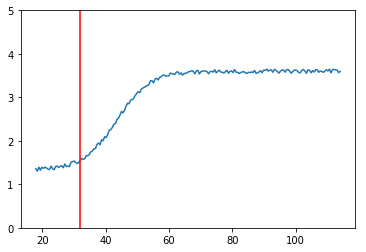

In [4]:
# plotting func
cg = CurveGen(size=200, noise=0.1, width=0.2, mid=30,
              folded_base=[2], prob_missing=0.5, missing_size=(1,10))
#cg.set_base(unfolded=[-0.0001, 0.01, 3])
cg.randomize_params(start=(10, 20), end=(80,120), mid=(40, 60), width=(0.01, 0.2),
                   folded=[(1,3)], unfolded=[(0,4)])

frac_target = 0.1
x, y = cg.generate_curve()
t = cg.get_frac_temp(frac_target)
# get classification value
print("*** clf target: ", cg.get_clf_target(sig_tresh=1, min_width=0.05))

# plot the curve
plt.plot(x, y)
plt.ylim(0, 5)
plt.axvline(t, color="r")

## Generate benchmark set (JSON)

In [5]:
cg = CurveGen(noise=0.1)
vary_params = {"mid":(15, 100),
               "width":(0.01, 0.2),
               "folded":[(1,3), (-0.001, 0.001), (-0.0001, 0.0001)],
               "unfolded":[(0,4), (-0.001, 0.001), (-0.0001, 0.0001)],
               "noise":(0.05, 1),
               "prob_missing":(0.0, 0.7),
               "missing_size":(1, 15),
               "size":(400, 450),
               "start":(15, 25),
               "end":(90, 120)
              }

curves = make_benchmark_set_json(cg, vary_params, 3000, replicas=1, frac=0.1)
pd.DataFrame(curves)

,clf_target,id,reg_target,signal,temp
0,1,1,15.610391,"[1.90521208971, 1.92325174905, 1.92726222522, ...","[20.0, 20.1931034483, 20.3862068966, 20.579310..."
1,1,2,33.543807,"[1.92602526417, 1.76440238592, 2.2522317359, 2...","[19.0, 19.2156862745, 19.431372549, 19.6470588..."
2,1,3,24.702470,"[1.21240297094, 1.17517526996, 1.23188320741, ...","[19.0, 19.1944444444, 19.3888888889, 19.583333..."
3,0,4,NaN,"[2.21551897969, 2.62245453816, 1.75058536427, ...","[22.0, 22.2289156627, 22.4578313253, 22.686746..."
4,0,5,NaN,"[2.14405106424, 2.12135834195, 2.13487161866, ...","[18.0, 18.2279069767, 18.4558139535, 18.683720..."
5,1,6,25.443175,"[2.83633828675, 2.74630990785, 2.87244855231, ...","[21.0, 21.2337349398, 21.4674698795, 21.701204..."
6,1,7,12.309377,"[1.6290122478, 1.7211362554, 1.52135352961, 2....","[23.0, 23.1698113208, 23.3396226415, 23.509433..."
7,1,8,17.181599,"[2.04226123412, 2.25239445637, 2.34014215083, ...","[22.0, 22.1790697674, 22.3581395349, 22.537209..."
8,1,9,68.144230,"[2.04884129803, 2.07732528373, 2.15822664551, ...","[16.0, 16.230248307, 16.460496614, 16.69074492..."
9,1,10,50.483504,"[1.95500029104, 1.78272325229, 1.89940001108, ...","[15.0, 15.1786542923, 15.3573085847, 15.535962..."


In [ ]:
# plot all the curves
for curve in curves:
    plt.plot(curve["temp"], curve["signal"])
    # mark the targets
    plt.axvline(curve["reg_target"])

## Generate benchmark set (CSV)

In [160]:
# create a CurveGen instance
cg = CurveGen(noise=0.1)
# the vary parameters for generating the benchmark set
vary_params = {"mid":(15, 90),
               "width":(0.01, 0.2),
               "folded":[(1,3), (-0.001, 0.001), (-0.0001, 0.0001)],
               "unfolded":[(0,4), (-0.001, 0.001), (-0.0001, 0.0001)],
               "noise":(0.05, 1),
               "prob_missing":(0.0, 0.7),
               "missing_size":(1, 15),
               "size":(400, 450),
               "start":(15, 25),
               "end":(90, 120)
              }

data, clf_targets, reg_targets = make_benchmark_set(cg, vary_params, 1000, replicas=3, frac=0.1)

### Export the data as JSON

In [174]:
# serialize as JSON
curves_json = json.dumps(curves)
# save to file
with open('benchmark_set.json', 'w') as outfile:
    json.dump(curves_json, outfile)